# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  
import os
from PIL import Image, ImageFile

import torch
import torchvision
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

ImageFile.LOADTRUNCATEDIMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


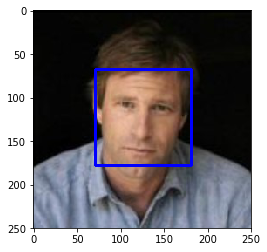

In [2]:
                          
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)
- What percentage of the first 100 images in human_files have a detected human face?
  
  <font color='red'>96%</font>
- What percentage of the first 100 images in dog_files have a detected human face?
  
  <font color='red'>18%</font>

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

num_human_face_detected = np.average([face_detector(img) for img in human_files_short] )
num_dog_face_detected = np.average([face_detector(img) for img in dog_files_short] )
print(num_human_face_detected)
print(num_dog_face_detected)

0.96
0.18


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [7]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [8]:

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''   
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path)
    #print(img.shape)    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406],
                                                       std=[0.229,0.224,0.225])])
    img = transform(img)
    img = img.unsqueeze(0) 
    img = Variable(img.cuda())
    predictions = VGG16(img)
    predicted_label = predictions.data.cpu().numpy().argmax()

    return predicted_label # predicted class index

print(VGG16_predict(dog_files_short[0]))

252


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted_label = VGG16_predict(img_path)
               
    return 151<= predicted_label <=268
print('is '+dog_files_short[0]+' a dog? \n',dog_detector(dog_files_short[0]))
print('is '+human_files_short[0]+' a dog? \n',dog_detector(human_files_short[0]))

is dog_images\test\001.Affenpinscher\Affenpinscher_00003.jpg a dog? 
 True
is lfw\Aaron_Eckhart\Aaron_Eckhart_0001.jpg a dog? 
 False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- What percentage of the images in `human_files_short` have a detected dog?  

  <font color='red'>0%</font>
- What percentage of the images in `dog_files_short` have a detected dog?

  <font color='red'>93%</font>

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
num_human_face_detected = np.average([dog_detector(img) for img in human_files_short] )
num_dog_face_detected = np.average([dog_detector(img) for img in dog_files_short] )
print(num_human_face_detected)
print(num_dog_face_detected)

0.0
0.94


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_workers = 0
batch_size = 16

transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5, resample=False, fillcolor=0),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_ = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485,0.456,0.406],
                                                   std=[0.229,0.224,0.225])])

dog_images_train = datasets.ImageFolder('dog_images/train/',transform=transform_train)
dog_images_valid = datasets.ImageFolder('dog_images/valid/',transform=transform_)
dog_images_test = datasets.ImageFolder('dog_images/test/',transform=transform_)
loaders_scratch ={ 'train':torch.utils.data.DataLoader(dog_images_train,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers=num_workers),
          'valid':torch.utils.data.DataLoader(dog_images_valid,
                                           batch_size = batch_size,
                                           num_workers=num_workers),
          'test':torch.utils.data.DataLoader(dog_images_test,
                                           batch_size = batch_size,
                                           num_workers=num_workers)}
class_names = dog_images_train.classes
print(len(dog_images_train))
print(len(loaders_scratch['train'].dataset) )

6680
6680


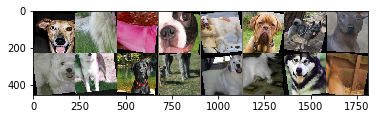

In [13]:
def imshow(img):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img,0.0, 1.0)
    plt.imshow(img)

imgs, classes = next(iter(loaders_scratch['train']))
out = torchvision.utils.make_grid(imgs)
imshow(out)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

  <font color='red'>The input image size for VGG is 224, therefore the input image before resizing is chosen to be bigger than this value: 256. If resize value is chosen to be 224, the padding has to be defined</font> 

- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

  <font color='red'>Given total number of class as 133, more training data is better to overcome imbalance among classes. The data augmention include: resize, crop, flip, rotate, shift, shear, scale, brightness, contrast, saturation and hue</font> 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [14]:

# define the CNN architecture
n_classes = 133
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2))        
        
        self.fc1 = nn.Linear(64 * 28 * 28,200)
        self.fc2 = nn.Linear(200,n_classes)
        self.dropout = nn.Dropout(0.3)
        
        ## Define layers of a CNN
    
    def forward(self, x):
        ## Define forward behavior
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)        
        x = x.view(x.size(0),-1)
        x = self.dropout(x)        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
   
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=133, bias=

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

 <font color='red'>$Three$ $convolution$ $layers:$ the first conv layer is to extract the basic features, and the second and third layers are to combine those basic features into more complex features. </font> <br><br>
<font color='red'>This classification task is not like classfying dog against human, which has quite clear different features between these two class. The task in this project is to classify breeds of dog, challenge here is that all those dogs images are already very similar to each other, it tries to tell very trivial difference among dog category, the ituition is 3 or more conv layers is better </font> <br><br> 
 <font color='red'>$Two$ $fully$ $connected$ $layers:$ the first fully connected layers converts the  features from the 2nd conv layer into high level features and last layer predicts the class.
Dropout layer is included to reduce overfitting</font>

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.001,momentum=0.9)
lr = lr_scheduler.StepLR(optimizer_scratch , step_size=30, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda,lr, save_path,pretrained=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        lr.step()
        print('Learning rate is: \t',lr.get_lr())

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_corrects = 0.0
        valid_corrects = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        if pretrained:
            for module in model.modules():
                if isinstance(module, torch.nn.modules.BatchNorm1d):
                    module.eval()
                if isinstance(module, torch.nn.modules.BatchNorm2d):
                    module.eval()
                if isinstance(module, torch.nn.modules.BatchNorm3d):
                    module.eval()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            if isinstance(output, tuple):
                loss = criterion(output[0], target)                     
                _,preds = torch.max(output[0].data,1) 
            else:
                loss = criterion(output, target)
                _,preds = torch.max(output.data,1)             
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_corrects +=torch.sum(preds ==target.data)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            if isinstance(output, tuple):
                loss = criterion(output[0], target)              
                _,preds = torch.max(output[0].data,1) 
            else:
                loss = criterion(output, target)
                _,preds = torch.max(output.data,1)                    
            valid_loss += loss.item() * data.size(0)
            valid_corrects +=torch.sum(preds ==target.data)          
            
        train_loss = train_loss /len(loaders['train'].dataset) 
        train_acc  = train_corrects.double() / len(loaders['train'].dataset) 
        valid_loss = valid_loss /len(loaders['valid'].dataset)   
        valid_acc  = valid_corrects.double()  / len(loaders['valid'].dataset) 
       
        # print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.4f} \tTraing Acc: {:.4f}\tValid Loss: {:.4f}\tValid Acc: {:.4f}'.format(
            epoch, n_epochs,
            train_loss, train_acc,
            valid_loss, valid_acc
            ))

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


In [17]:
# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, lr, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Learning rate is: 	 [0.001]
Epoch: 1/25 	Training Loss: 4.9917 	Traing Acc: 0.0147	Valid Loss: 4.6539	Valid Acc: 0.0299
Learning rate is: 	 [0.001]
Epoch: 2/25 	Training Loss: 4.7132 	Traing Acc: 0.0293	Valid Loss: 4.5357	Valid Acc: 0.0407
Learning rate is: 	 [0.001]
Epoch: 3/25 	Training Loss: 4.6270 	Traing Acc: 0.0298	Valid Loss: 4.4677	Valid Acc: 0.0527
Learning rate is: 	 [0.001]
Epoch: 4/25 	Training Loss: 4.5603 	Traing Acc: 0.0374	Valid Loss: 4.4135	Valid Acc: 0.0503
Learning rate is: 	 [0.001]
Epoch: 5/25 	Training Loss: 4.5306 	Traing Acc: 0.0421	Valid Loss: 4.3617	Valid Acc: 0.0491
Learning rate is: 	 [0.001]
Epoch: 6/25 	Training Loss: 4.4797 	Traing Acc: 0.0507	Valid Loss: 4.3572	Valid Acc: 0.0503
Learning rate is: 	 [0.001]
Epoch: 7/25 	Training Loss: 4.4610 	Traing Acc: 0.0509	Valid Loss: 4.3036	Valid Acc: 0.0551
Learning rate is: 	 [0.001]
Epoch: 8/25 	Training Loss: 4.4415 	Traing Acc: 0.0527	Valid Loss: 4.2910	Valid Acc: 0.0707
Learning rate is: 	 [0.001]
Epoch: 9/25 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        if isinstance(output, tuple):
            loss = criterion(output[0], target)                 
            pred = output[0].data.max(1, keepdim=True)[1]            
        else:
            loss = criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1]     
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.829246


Test Accuracy: 11% (96/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
## TODO: Specify data loaders
## TODO: Specify data loaders
import os
import torchvision
from torchvision import datasets
ImageFile.LOADTRUNCATEDIMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_workers = 0
batch_size = 16
transform_ = transforms.Compose([transforms.Resize((299,299)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485,0.456,0.406],
                                                   std=[0.229,0.224,0.225])])

transform_train = transforms.Compose([
        transforms.Resize(322),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5, resample=False, fillcolor=0),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.5),
        #transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

data_transfer = {'train':datasets.ImageFolder('dog_images/train/',transform=transform_train),
                 'valid':datasets.ImageFolder('dog_images/valid/',transform=transform_),
                 'test': datasets.ImageFolder('dog_images/test/',transform=transform_) }

loaders_transfer ={ 'train':torch.utils.data.DataLoader(data_transfer['train'],
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers=num_workers),
          'valid':torch.utils.data.DataLoader(data_transfer['valid'],
                                           batch_size = batch_size,
                                           num_workers=num_workers),
          'test':torch.utils.data.DataLoader(data_transfer['test'],
                                           batch_size = batch_size,
                                           num_workers=num_workers)}
class_names = dog_images_train.classes
print(class_names[1])
print(class_names[1][4:].replace("_", " "))
print(len(loaders_transfer['train'].dataset) )

002.Afghan_hound
Afghan hound
6680


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
#import torchvision.models as models
from inception_dog import inception_v3
import torch.nn as nn

## TODO: Specify model architecture 
# define Inception_V3 model
#model_transfer = models.inception_v3(pretrained=True)
model_transfer = inception_v3(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False

num_features = model_transfer.fc_dog_breed.in_features
model_transfer.fc_dog_breed = torch.nn.Linear(num_features,n_classes)

use_cuda = torch.cuda.is_available()
# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
<font color='red'> 
Here inception_v3 network is chosen for this classification task. The main reasons choosing this network are:<br>
    a. Very good performance on imagemet<br>
    b. Smaller size  when compared against other networks,like VGG and Resnet<br><br>
    
To save the size of final model, both $dog-vs-other$ classes classification and $dog$ $breed$ classificaton task are merged intao a single inception_v3 model by adding one extra output port2 of size 133. With its original output of size(1,1000), this model can predict whether it a dog, cat or car, it can also predict dog breed<br><br>
During training, all layers parameters are freezed, including $batch$ $normalization$ layers. Only those parameters related added output port2 (1,133) get trained
</font>

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [21]:
criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.fc_dog_breed.parameters(), lr=0.001, momentum=0.9)

lr = lr_scheduler.StepLR(optimizer_transfer, step_size=30, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [22]:
# train the model
n_epochs = 5
model_transfer =train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, \
                      criterion_transfer, use_cuda, lr, 'model_transfer.pt',pretrained=True)



Learning rate is: 	 [0.001]
Epoch: 1/5 	Training Loss: 4.0991 	Traing Acc: 0.3024	Valid Loss: 3.0118	Valid Acc: 0.7018
Learning rate is: 	 [0.001]
Epoch: 2/5 	Training Loss: 2.7276 	Traing Acc: 0.5889	Valid Loss: 1.8374	Valid Acc: 0.7605
Learning rate is: 	 [0.001]
Epoch: 3/5 	Training Loss: 1.9762 	Traing Acc: 0.6501	Valid Loss: 1.2507	Valid Acc: 0.8180
Learning rate is: 	 [0.001]
Epoch: 4/5 	Training Loss: 1.6024 	Traing Acc: 0.6864	Valid Loss: 0.9543	Valid Acc: 0.8419
Learning rate is: 	 [0.001]
Epoch: 5/5 	Training Loss: 1.3800 	Traing Acc: 0.7150	Valid Loss: 0.7888	Valid Acc: 0.8551


In [23]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [24]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.846807


Test Accuracy: 83% (701/836)


### Re-define dog_detector funtion for inception_v3 to detect if it is a dog

In [25]:
def preprocess_img(img_path, resize=(299,299)):
    '''
    This function is to read in image, resize and normalize it
    img_path:  a file path to an image
    resize = (299,299) for inception_v3, and (224,224) for VGG
    '''
    img = Image.open(img_path)
    #print(type(img))    
    transform = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406],
                                                       std=[0.229,0.224,0.225])])
    img = transform(img)
    img = img.unsqueeze(0) 
    img = Variable(img.cuda())
    return img

In [26]:
def dog_detector(model, img_path):
    ## TODO: Complete the function.
    img = preprocess_img(img_path)
    pred = model(img)
    if isinstance(pred, tuple): #for inception_v2, output is tuple
        predicted_label = pred[1].data.cpu().numpy().argmax()
    else:
        predicted_label = pred.data.cpu().numpy().argmax()        
    return 151<= predicted_label <=268


In [27]:
model_transfer.eval()
num_human_face_detected = np.average([dog_detector(model_transfer,img) for img in human_files_short] )
num_dog_face_detected = np.average([dog_detector(model_transfer,img) for img in dog_files_short] )
print("{}% of human faces been classified as dog".format(num_human_face_detected*100))
print("{}% of dogs been classified as dog".format(num_dog_face_detected*100))


0.0% of human faces been classified as dog
95.0% of dogs been classified as dog


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [28]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
#print(class_names)
def dog_breed_predictor(model,img_path):
    # load the image and return the predicted breed
    img = preprocess_img(img_path)
    predictions = model(img)
    if isinstance(predictions,tuple): #for inception_v2, output is tuple
        predicted_label = predictions[0].data.cpu().numpy().argmax()
    else:
        predicted_label = predictions.data.cpu().numpy().argmax()
    return class_names[predicted_label] # predicted dog breed name    


The following clas_names_2_int is to create a dictionary with key as dog breed name and values are index for the corresponding breed

In [29]:
class_names_2_int={}
for i in range(len(data_transfer['test'])):
    dog_breed = class_names[data_transfer['test'][i][1]]

    try:
        class_names_2_int[dog_breed].append(i)
    except:
        class_names_2_int.update({dog_breed:[i]})

In [30]:
list(class_names_2_int.items())[0:2]

[('Affenpinscher', [0, 1, 2, 3, 4, 5, 6, 7]),
 ('Afghan hound', [8, 9, 10, 11, 12, 13, 14, 15])]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [31]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import random
def img_unnormalize(img):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img,0.0, 1.0)
    return img

def run_app(model,img_path):
    
    name_of_img = " ".join(img_path.split('\\')[-1].split('.')[0].split('_')[:-1])
    ## handle cases for dog, the input image and a predict image are both plot to compare
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(cv_rgb)
    dog_breed_predicted = dog_breed_predictor(model,img_path)
    dog_breed_idx = class_names_2_int[dog_breed_predicted]
    dog_img_idx = random.randint(0,len(dog_breed_idx)-1)
    dog_img = data_transfer['test'][class_names_2_int[dog_breed_predicted][dog_img_idx]][0]
    dog_img = img_unnormalize(dog_img)
    ax2.imshow(dog_img)
    
    if dog_detector(model,img_path):
        #fig.suptitle("The input dog breed  vs   predicted dog breed",fontsize=15) 
        ax1.set_title( name_of_img )          
        ax2.set_title('Hello, dog!\n you predicted breed is...:\n        '+dog_breed_predicted,loc='left')  
        fig.savefig('dog_detected/'+name_of_img+'.jpg')
        return dog_breed_predictor(model,img_path)   
    ## handle cases for a human face, the input face and predict dog breed are both ploted  
    elif face_detector(img_path):
        #fig.suptitle('Human face predicted as a dog breed',fontsize=20) 
        ax1.set_title('Human face detected\nHello: '+ name_of_img+"!\nYou look like a ... \n        "+\
                      dog_breed_predicted+' shown on the right',loc='left' )     
        ax2.set_title(dog_breed_predicted)           
        fig.savefig('human_face_detected/'+name_of_img+'.jpg')
        return dog_breed_predicted
    else:
        #ax1.set_title( 'No human face been detected in this picture' ) 
        ax1.set_title( name_of_img )          
        ax2.clear()         
        ax2.set_title('No human face or dog been detected',fontsize=10)     
        fig.savefig('no_human_face/'+name_of_img+'.jpg')
        return 

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
* <font color='red'> the output is better than I thought:
> <font color='red'> The accuracy is pretty high for dog breed prediction, even one sample (American eskimo dog) that default inception_v3 failed to predict it as a dog, the model still made a correct prediction for the dog breed. Also the human face and predicted dog breed shows some similar features, like hair color
* To improve the performance
> <font color='red'>1) There is one sample(American eskimo dog) the inception_v3 failed to predict correctly as a dog.To solve that failure, the original inception_v3 model's last few fully connected layers can be trained on this dog breed data set    
> <font color='red'>2) In this project, the algorithm for human face detector is $Haar feature-based cascade classifiers$, which wrongly detect sample(American eskimo dog) as human face shown in the following cell. Other better face detection algorithm could be used
    </font>

Is the following a dog?  False
Is the following a human face?  True


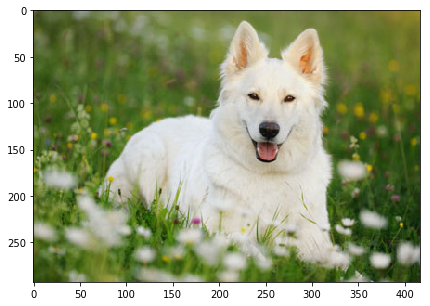

In [32]:
# this cell is to show one picture which both inception_v3 and face_detector fail to make a correct prediction
import torchvision.models as models
# define inception_v3 model
model_inception_v3 = models.inception_v3(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_inception_v3 = model_inception_v3.cuda()
    
model_inception_v3.eval()    
img_path = "test_images/american_white_shepherd_(from_internet)_dog.jpg"
img = cv2.imread(img_path)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
fig = plt.figure(figsize=(10,5))
plt.imshow(cv_rgb)

print("Is the following a dog? ",dog_detector(model_inception_v3,img_path))
print("Is the following a human face? ",face_detector(img_path))

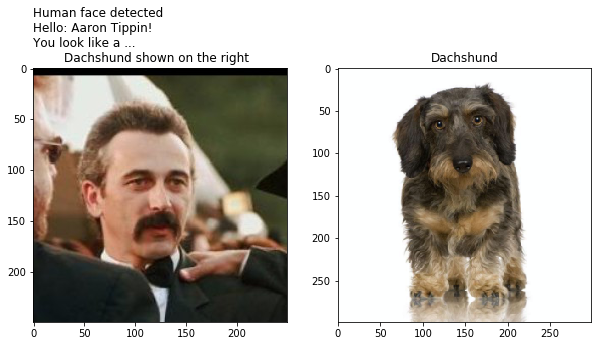

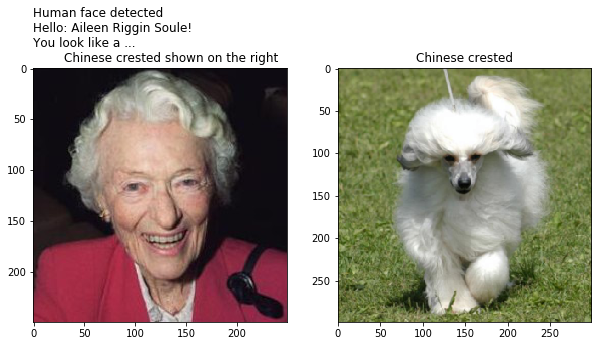

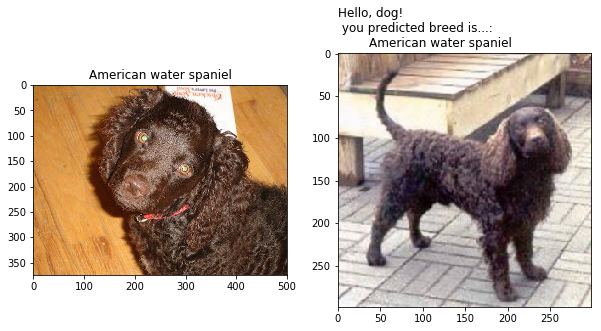

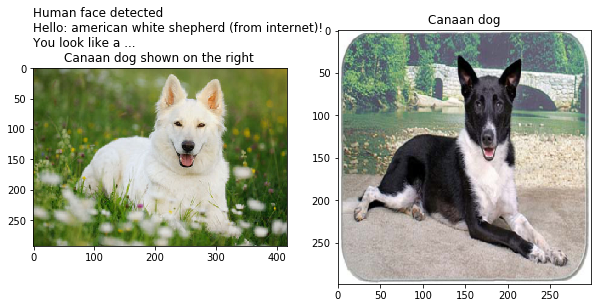

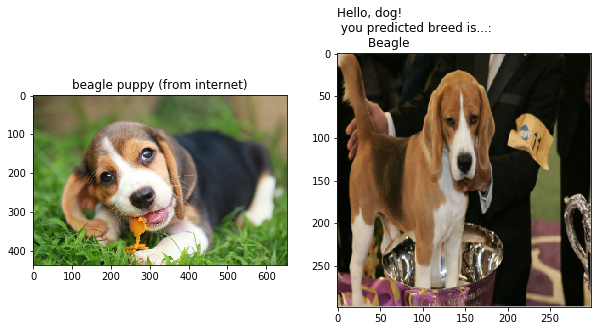

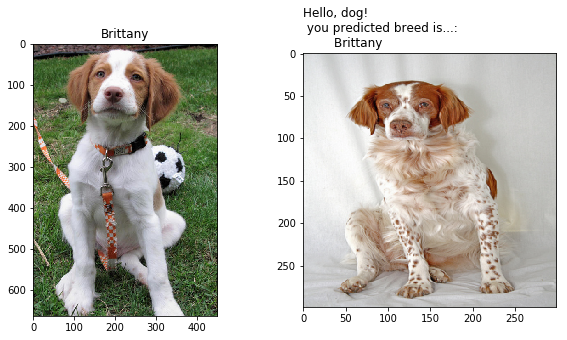

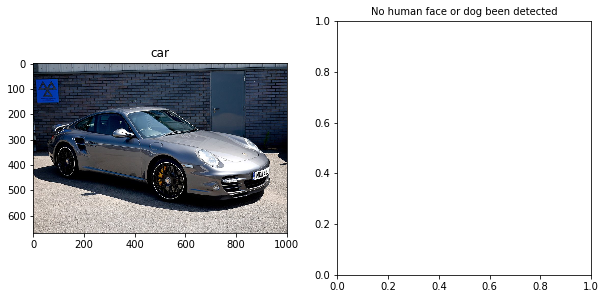

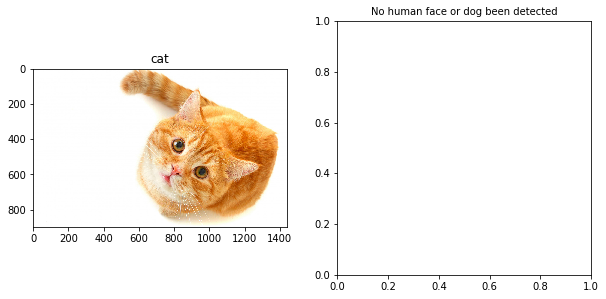

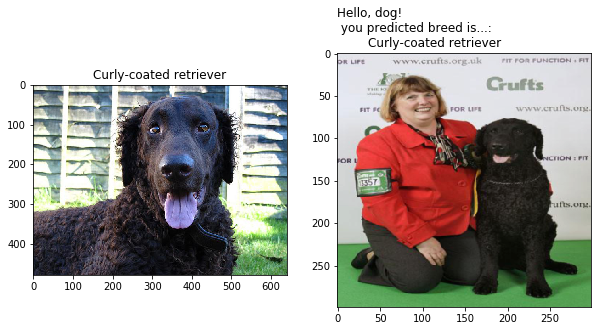

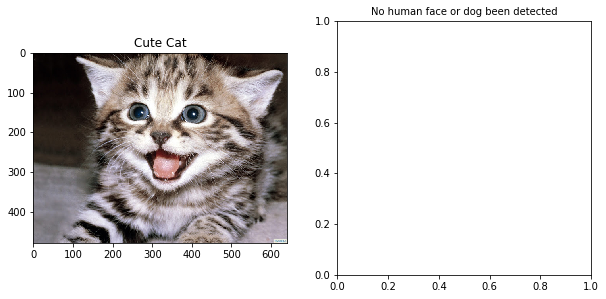

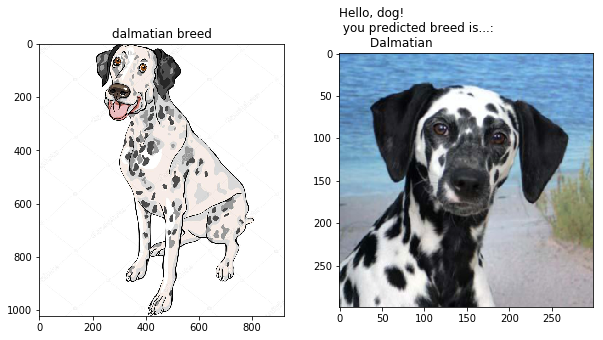

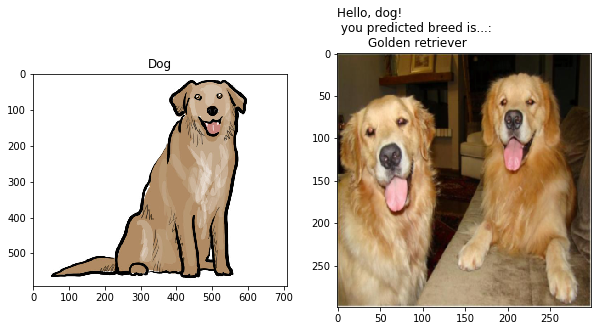

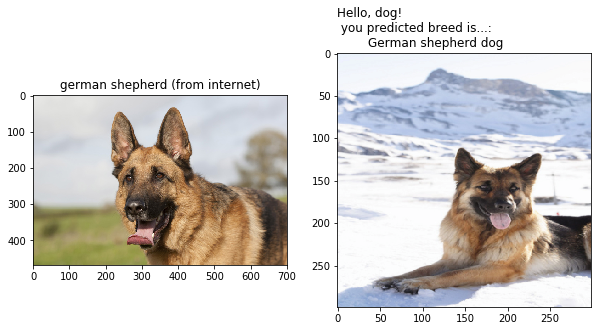

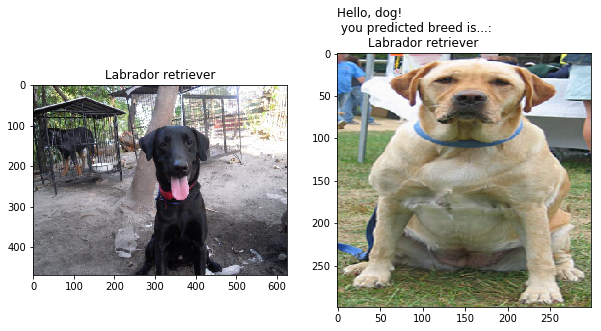

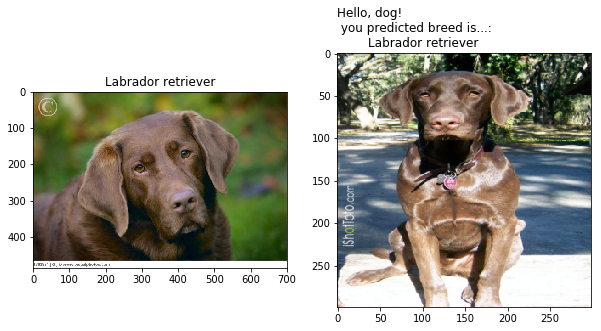

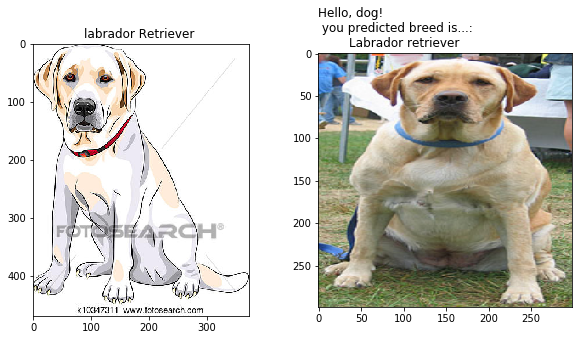

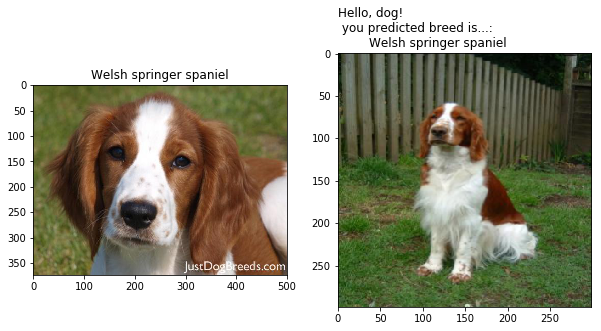

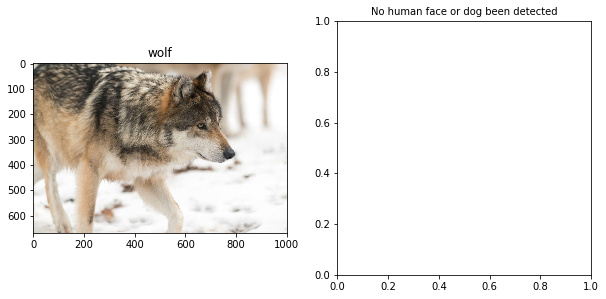

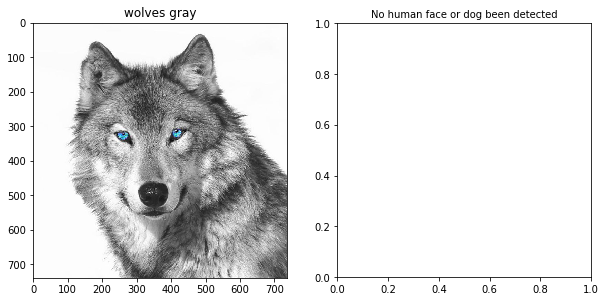

In [33]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
model_transfer.eval()
imgs_path = np.array(glob("test_images/*"))
#for file in np.hstack((human_files[:3], dog_files[:3])):
for file in imgs_path:
    #print(file)
    run_app(model_transfer,file)